In [1]:
# Explorations of trip data downloaded from Parse on 2013-06-23.
# Shripad Thite (shripad@trueride.co), 03-July-2013.

In [2]:
import datetime
import dateutil
import json
import matplotlib.pyplot as plt
import numpy
import os
import pprint
import pylab
import random
from scipy import stats
import urllib

In [3]:
PARSE_API_ROOT="https://api.parse.com/1/classes"
PARSE_APPLICATION_ID="TUhYWyWMr2t7rN0rfMJ72FacxOCamnHXXLCkkRir"
PARSE_REST_API_KEY="UxSCdWZMnQY9hA51OeqVfDl7LSfQfDRgZwZEJft4"

In [4]:
def get_trips():
    params = urllib.parse.urlencode({"limit" : "1000"
     })
    uri = PARSE_API_ROOT + "/Trips?" + params
    print(uri)
    request = urllib.request.Request(uri)
    request.add_header("Content-Type", "application/json")
    request.add_header("X-Parse-Application-Id", PARSE_APPLICATION_ID)
    request.add_header("X-Parse-REST-API-Key", PARSE_REST_API_KEY)
    
    try:
        response = urllib.request.urlopen(request)
    except Exception as e:
        print("Error %s", e)
        return None
    
    encoding = response.headers.get_content_charset()
    return json.loads(response.read().decode(encoding))

In [5]:
def get_trip_data_points_from_parse(trip_id):
    params = urllib.parse.urlencode({"where" : json.dumps({
       "trip_object_id": trip_id
     })})
    uri = PARSE_API_ROOT + "/DataPoints?" + params
    print(uri)
    request = urllib.request.Request(uri)
    request.add_header("Content-Type", "application/json")
    request.add_header("X-Parse-Application-Id", PARSE_APPLICATION_ID)
    request.add_header("X-Parse-REST-API-Key", PARSE_REST_API_KEY)
    
    try:
        response = urllib.request.urlopen(request)
    except Exception as e:
        print("Error %s" % e)
        return None
    
    encoding = response.headers.get_content_charset()
    return json.loads(response.read().decode(encoding))

In [6]:
def get_trip_data_points_from_file(trip_id, filename):
    data = None
    with open(filename, "r") as f:
        data = json.loads(f.read())
    return data
    

In [7]:
def concatenate_data_results(trip_id, data):
    # The data points for each trip have been partitioned into chunks,
    # each chunk identified by the trip ID. Collect the data points
    # for each trip and sort them by their timestamp.
    trip_data_points = []
    for chunk in data["results"]:
        if chunk["trip_object_id"] != trip_id:
            print("Incorrect trip_object_id=[%s] != [%s]", chunk["trip_object_id"], trip_id)
            return None
        trip_data_points.extend(chunk['data_points'])
    return trip_data_points

In [8]:
# WARNING: The following sort() operation is expensive!
def sort_trip_data_points(trip_data_points):
    point = trip_data_points[0]
    timestamp_in_ms = False
    try:
        if point["timestamp"] > 0:
            timestamp_in_ms = True
    except:
        timestamp_in_ms = False
        
    if timestamp_in_ms:
            trip_data_points.sort(key=lambda p: p["timestamp"])
    else:
        trip_data_points.sort(key=lambda k: dateutil.parser.parse(k['timestamp']['iso']))

In [9]:
# Apply a moving average filter to the input.
def moving_average_filter(measurements, window_width):
    window_width = int(window_width)
    window = [1.0 / window_width] * window_width
    return numpy.convolve(measurements, window, mode='same')

In [10]:
# Apply a Kalman filter to the input.
def kalman_filter(measurements, p, q, r):
    """Parameters of the Kalman filter:
    P = initial estimated error
    Q = process noise
    R = sensor noise
    """
    filtered = numpy.zeros(numpy.shape(measurements))
    filtered[0] = measurements[0]
    for i in range(1, len(measurements)):
        p = p + q
        k = p / (p + r)
        filtered[i] = (filtered[i-1] + k * (measurements[i] - filtered[i-1]))
        p = (1 - k) * p
        
    return filtered

In [11]:
# Use a Kalman filter to identify "events" in the input.
kNeutralEvent = '.'
kAccelerationEvent = '^'
kDecelerationEvent = 'v'
def kalman_filter_events(measurements, p, q, r, min_significant_measurement, alpha, beta):
    """Parameters of the Kalman filter:
    P = initial estimated error
    Q = process noise
    R = sensor noise
    """
    events_list = []
    filtered = numpy.zeros(numpy.shape(measurements))
    filtered[0] = measurements[0]
    events_list.append(kNeutralEvent)
    for i in range(1, len(measurements)):
        p = p + q
        k = p / (p + r)
        delta = k * (measurements[i] - filtered[i-1])
        filtered[i] = (filtered[i-1] + delta)
        if measurements[i] >= min_significant_measurement and delta < alpha * filtered[i-1]:
            event = kDecelerationEvent
        elif measurements[i] >= min_significant_measurement and delta > beta * filtered[i-1]:
            event = kAccelerationEvent
        else:
            event = kNeutralEvent
        events_list.append(event)
        p = (1 - k) * p
        
    return filtered, events_list

In [17]:
def analyze_data(trip_id, data_points, show_plots=True):
    """
    trip_id: "e0y8o56azC"
    """
    if data is None:
        return None
    
    time_step = None
    duration_min = None
    
    point = data_points[0]
    timestamp_in_ms = False
    try:
        if point["timestamp"] > 0:
            timestamp_in_ms = True
    except:
        timestamp_in_ms = False
        
    print(timestamp_in_ms)
    if timestamp_in_ms:
        timestamps_ms = [point["timestamp"] for point in data_points]
        time_step_ms, _, _, _, _ = stats.linregress(arange(len(timestamps_ms)), timestamps_ms)
        time_step = time_step_ms / 1e3
        duration_sec = (timestamps_ms[-1] - timestamps_ms[0]) / 1e3
        duration_min = duration_sec / 60.0
    else:
        timestamps = [dateutil.parser.parse(point["timestamp"]["iso"]).timestamp() for point in data_points]
        time_step, _, _, _, _ = stats.linregress(arange(len(timestamps)), timestamps)
        duration_sec = timestamps[-1] - timestamps[0]
        duration_min = duration_sec / 60.0

    speeds = numpy.array([point["speed"] for point in data_points])
    
    window_size = int(2 * 1.0/time_step)  # approx. 2 seconds
    smoothed_speed = moving_average_filter(speeds, window_size)
    
    filtered, events = kalman_filter_events(smoothed_speed,
                                            p=1, q=1, r=1,
                                            min_significant_measurement=5,
                                            alpha=-0.05, beta=0.1)
                
    if show_plots:
        plt.figure(figsize=(8, 6), dpi=600)
        plt.title("Trip id [%s]" % trip_id)
        plt.plot(speeds, "y-", label="original")
        plt.plot(smoothed_speed, label="window=%d" % window_size)
        plt.legend()
        plt.plot(smoothed_speed, "g-")
        plt.plot(filtered, "r-", label="filtered")
        for i in range(len(events)):
            # Ignore events at too low speeds.
            if smoothed_speed[i] > 5:
                if events[i] == kAccelerationEvent:
                    plt.scatter(i, smoothed_speed[i], marker='^')
                elif events[i] == kDecelerationEvent:
                    plt.scatter(i, smoothed_speed[i], marker='o')
        plt.show()
    
    return numpy.array([events.count(kAccelerationEvent),
                        events.count(kDecelerationEvent)]) / duration_min

In [13]:
trip_id = "e0y8o56azC"
data = get_trip_data_points_from_parse(trip_id)
data_points = concatenate_data_results(trip_id, data)

https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22e0y8o56azC%22%7D


In [14]:
len(data_points)

12113

False


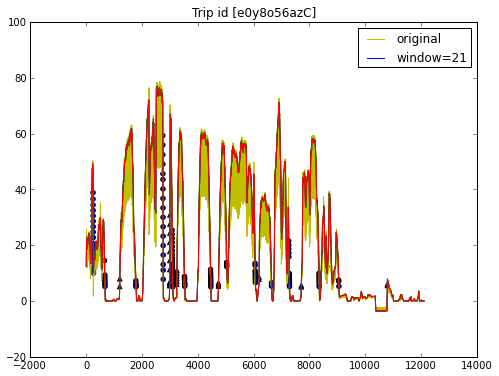

array([ 1.47272727,  7.14545455])

In [18]:
analyze_data(trip_id, data_points, show_plots=True)

In [20]:
trips = get_trips()
trips = trips["results"]
len(trips)

https://api.parse.com/1/classes/Trips?limit=1000


525

In [21]:
trips[0]

{'createdAt': '2013-06-04T17:10:33.686Z',
 'distance': 4.403121,
 'drive_time': 832.6442,
 'end_time': {'__type': 'Date', 'iso': '2013-06-03T23:28:12.000Z'},
 'objectId': 'e0y8o56azC',
 'start_time': {'__type': 'Date', 'iso': '2013-06-03T23:14:19.000Z'},
 'trip_name': '94025 16:14:19 -> 94025 16:28:12 -> 00:13:52',
 'udid': '6268142FB8284E0F82A26A1C109EB0FF',
 'updatedAt': '2013-06-04T17:10:33.686Z'}

In [22]:
trip_signatures = {}

e0y8o56azC
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22e0y8o56azC%22%7D
12113
False


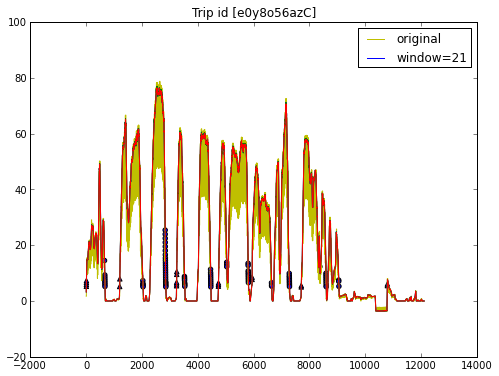

[ 1.05913504  4.81906443]
0tHcaDgq8c
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%220tHcaDgq8c%22%7D
6063
False


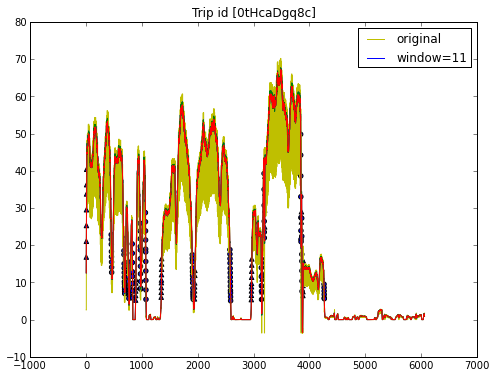

[ 3.78698225  7.15976331]
jiPp3Aihh7
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22jiPp3Aihh7%22%7D
501
False


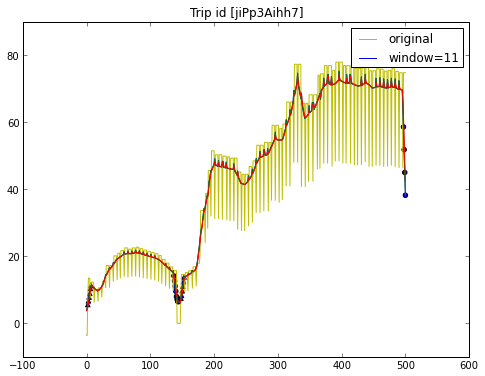

[ 8.47058824  8.47058824]
6jYYFHqpc3
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%226jYYFHqpc3%22%7D
501
False


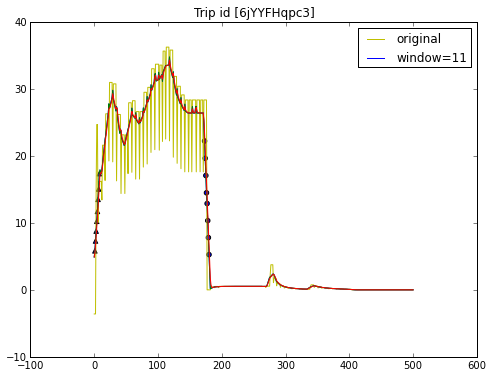

[ 5.51724138  5.51724138]
xqhhRfDUSB
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22xqhhRfDUSB%22%7D
251
False


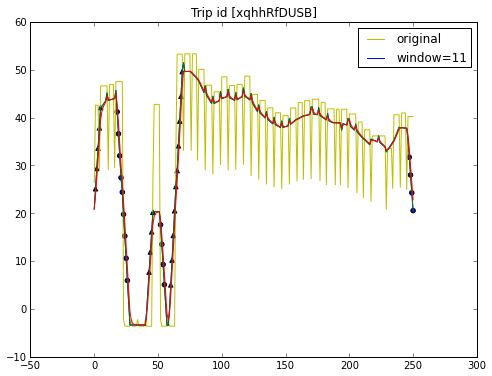

[ 26.51162791  23.72093023]
5bqdojA1UN
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%225bqdojA1UN%22%7D
8060
False


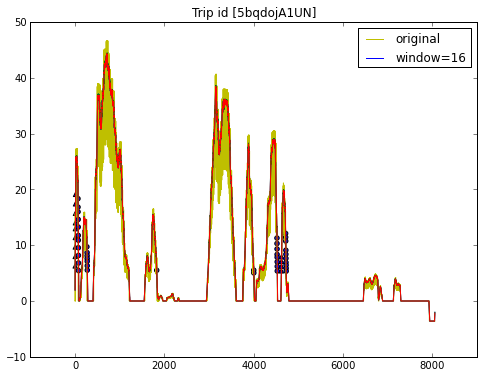

[ 0.77689243  2.33067729]
tx7KDNDftb
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22tx7KDNDftb%22%7D
12281
False


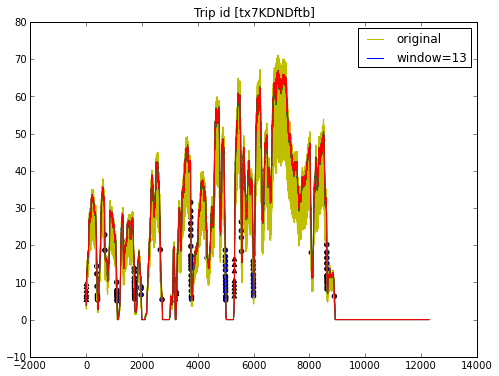

[ 0.55587724  3.68268674]
B2s1iFQkxx
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22B2s1iFQkxx%22%7D
25001
False


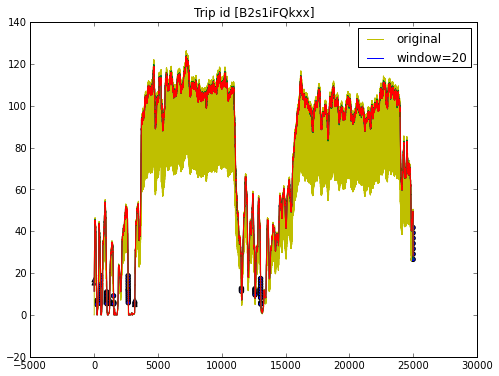

[ 0.25031289  1.82728411]
CnLYSX4SNx
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22CnLYSX4SNx%22%7D
0
nfZOqMExDw
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22nfZOqMExDw%22%7D
3219
False


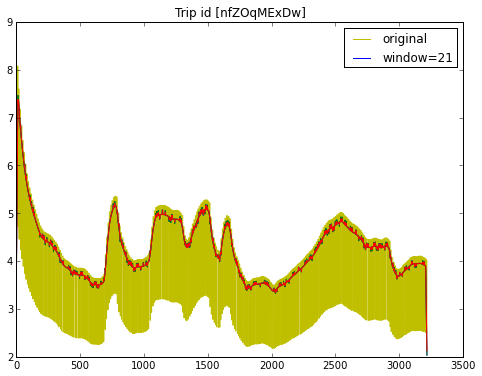

[ 0.  0.]
VJjBiyEEzp
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22VJjBiyEEzp%22%7D
7329
False


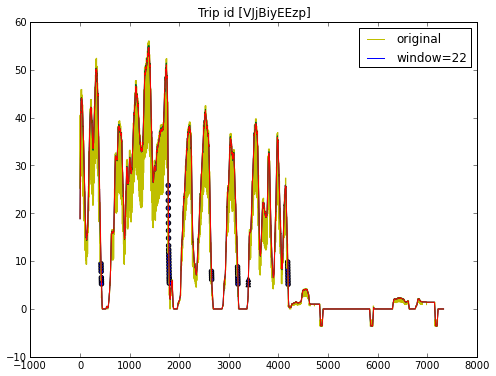

[ 0.2690583   4.66367713]
uw6jfQgWul
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22uw6jfQgWul%22%7D
3482
False


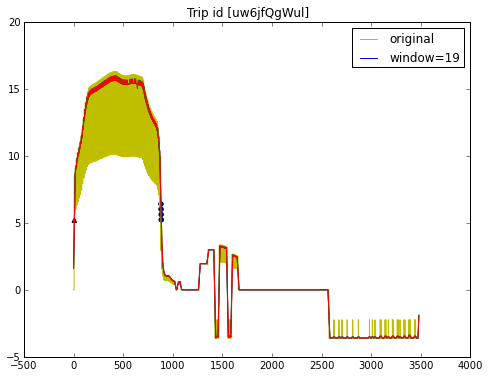

[ 0.15831135  0.63324538]
84a4S5T4sy
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%2284a4S5T4sy%22%7D
0
XzQLoXCk82
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22XzQLoXCk82%22%7D
4093
False


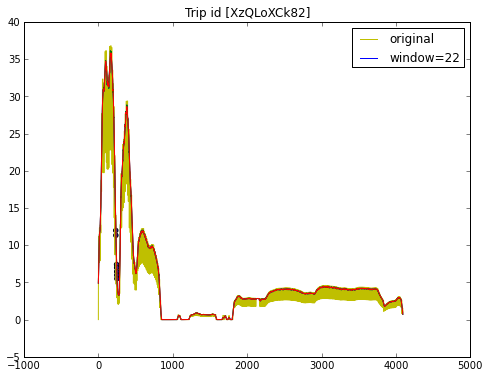

[ 0.          1.13207547]
wpoyAQrplT
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22wpoyAQrplT%22%7D
3220
False


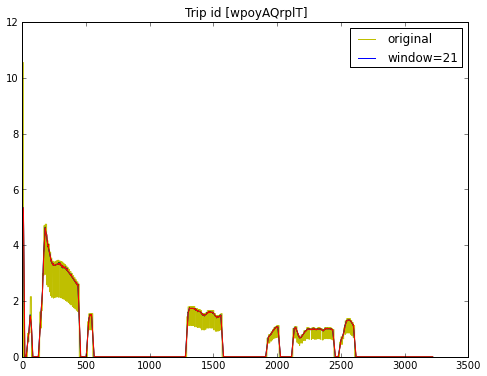

[ 0.  0.]
Fn2xFraxHb
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22Fn2xFraxHb%22%7D
14649
False


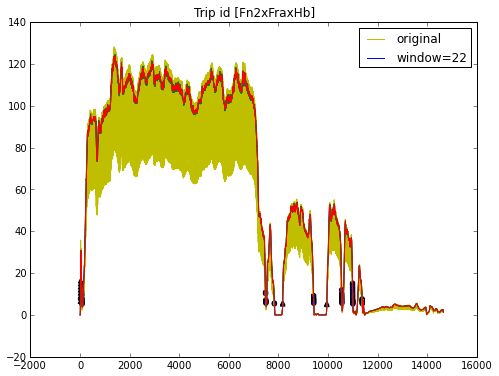

[ 0.53851907  2.64771877]
ZI4CUZPpZZ
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22ZI4CUZPpZZ%22%7D
25001
False


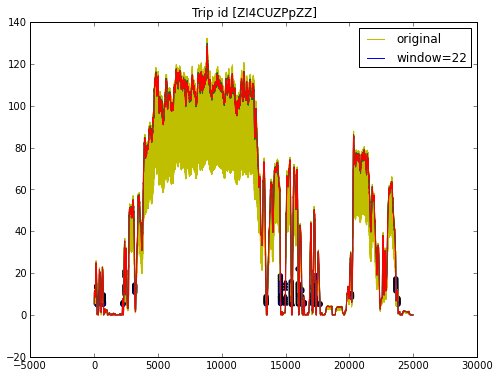

[ 0.48214286  4.33928571]
zHaXKl1Q6g
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22zHaXKl1Q6g%22%7D
5098
False


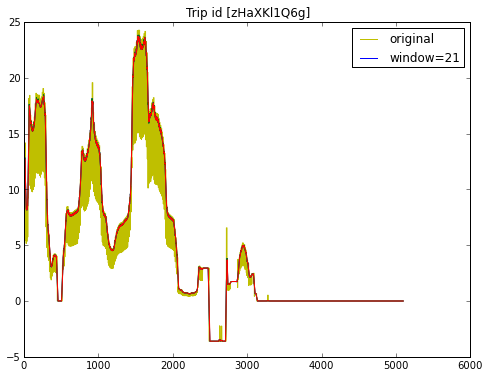

[ 0.  0.]
TEHFTXG3hz
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22TEHFTXG3hz%22%7D
6950
False


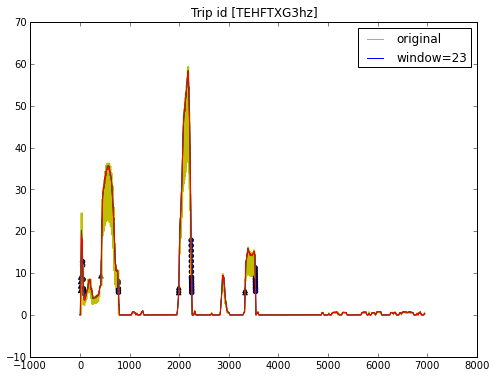

[ 1.05633803  3.8028169 ]
aG7Yuss6Oa
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22aG7Yuss6Oa%22%7D
9368
False


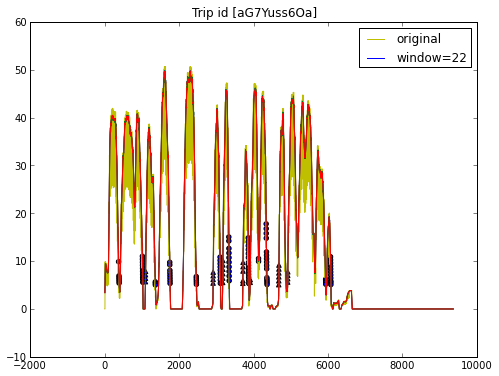

[ 2.23021583  6.97841727]
UjBFOEDrSf
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22UjBFOEDrSf%22%7D
772
False


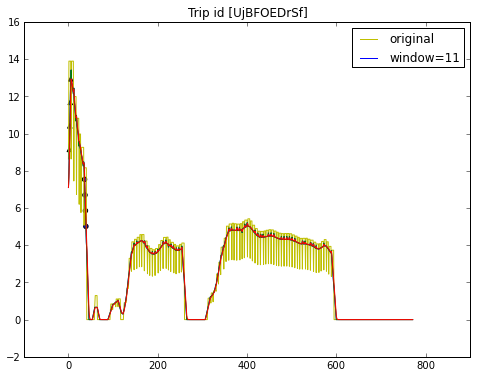

[ 1.83206107  1.83206107]
XeLvED03mS
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22XeLvED03mS%22%7D
808
False


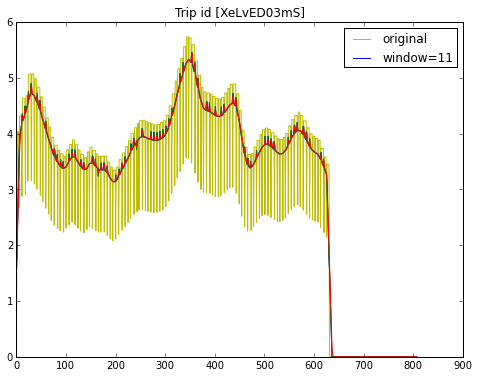

[ 0.  0.]
0uAuY9yFQt
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%220uAuY9yFQt%22%7D
0
p7qlCWJ547
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22p7qlCWJ547%22%7D
14462
False


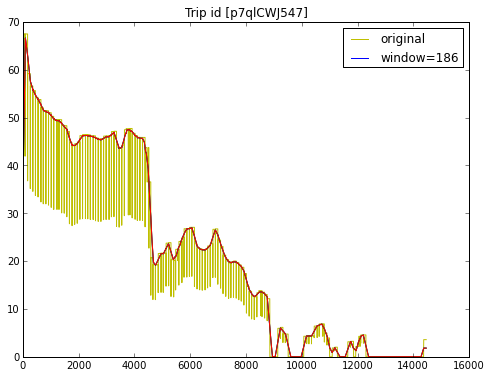

[ 0.  0.]
isw2hf2o2o
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22isw2hf2o2o%22%7D
0
wadDw30hFj
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22wadDw30hFj%22%7D
3257
False


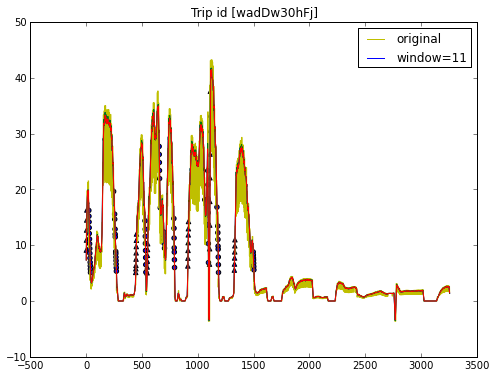

[ 4.44846293  8.35443038]
lh2CfWKiis
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22lh2CfWKiis%22%7D
25002
False


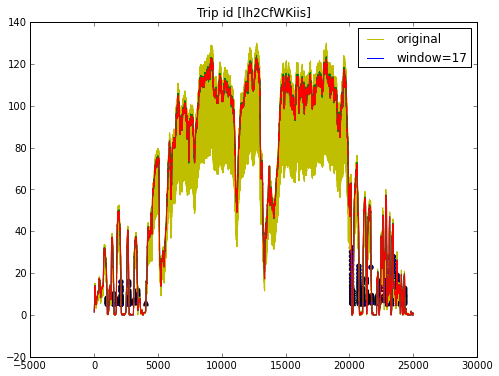

[ 1.05964678  3.79873376]
TMJZr6Ld44
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22TMJZr6Ld44%22%7D
140
True


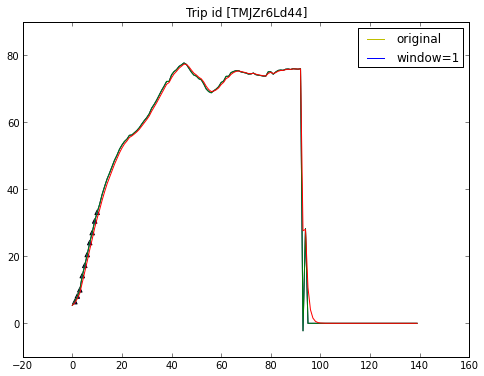

[ 4.08163265  0.        ]
WIZYiNKtaK
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22WIZYiNKtaK%22%7D
1680
True


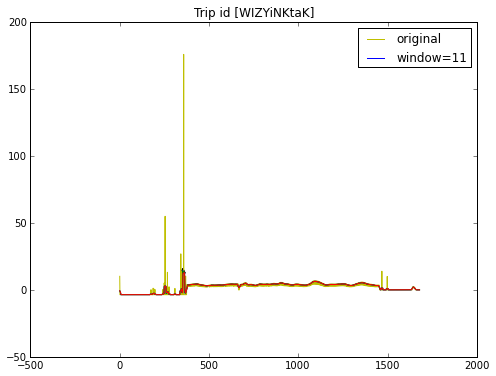

[ 0.40816327  0.        ]
uJcC7b8xNi
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22uJcC7b8xNi%22%7D
25002
True


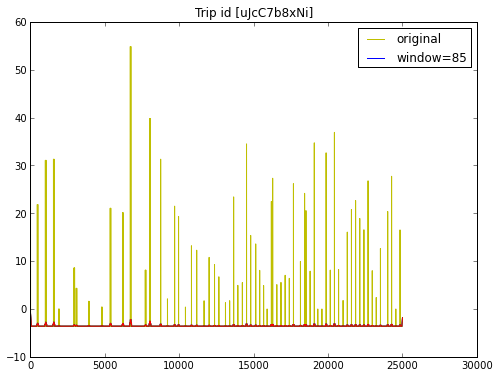

[ 0.  0.]
ryIJCZxvYC
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22ryIJCZxvYC%22%7D
0
n6khEwD4et
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22n6khEwD4et%22%7D
0
Nz91pA1vZ0
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22Nz91pA1vZ0%22%7D
0
jQB3YapfLJ
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22jQB3YapfLJ%22%7D
0
Vhl5GpTLg4
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22Vhl5GpTLg4%22%7D
0
utrwm6OpCW
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22utrwm6OpCW%22%7D
3550
False


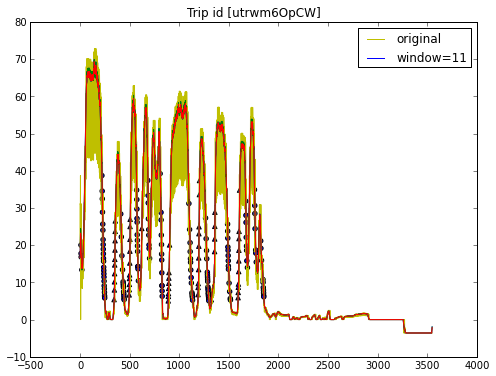

[  5.30278232  14.04255319]
ZVJp4Yel9A
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22ZVJp4Yel9A%22%7D
1754
False


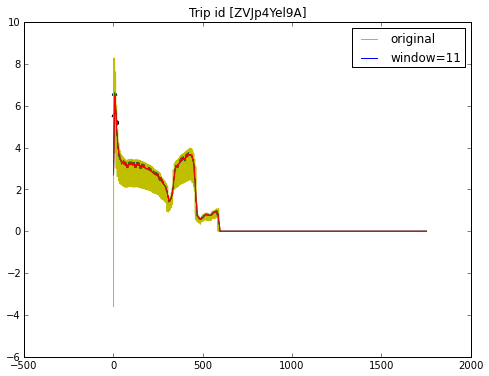

[ 0.3986711   0.19933555]
EjspLdBlVL
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22EjspLdBlVL%22%7D
4386
False


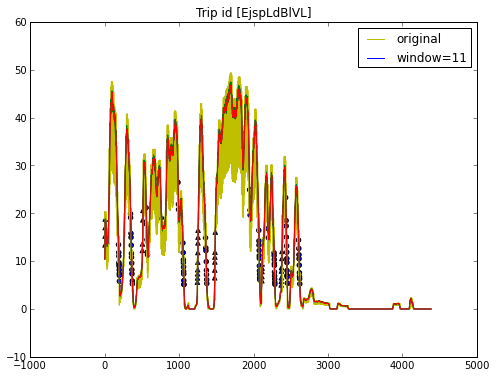

[ 2.92682927  7.96747967]
D9eILCMVGc
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22D9eILCMVGc%22%7D
3156
False


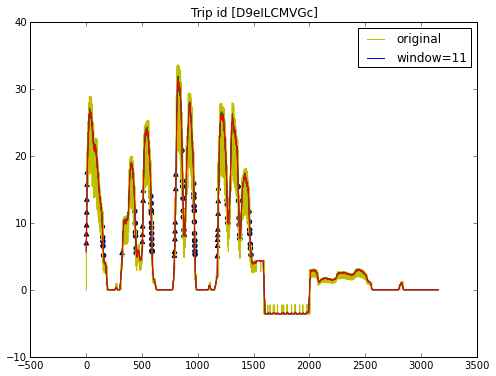

[ 3.07129799  6.47166362]
9xuYSD4Kwc
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%229xuYSD4Kwc%22%7D
5265
False


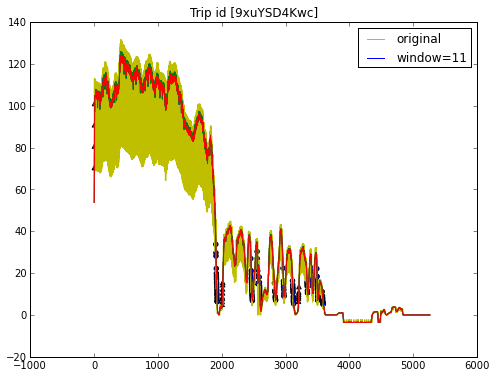

[ 1.323043    7.14443219]
19TMoJiuo4
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%2219TMoJiuo4%22%7D
8238
False


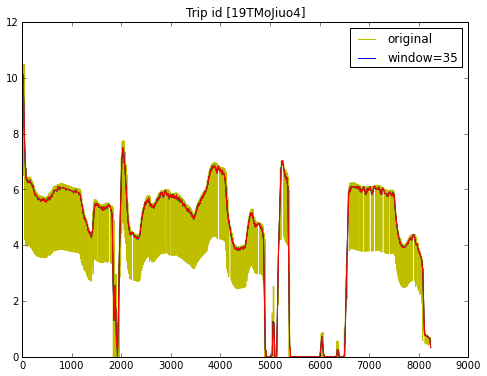

[ 0.  0.]
Em2S7ZK0Qq
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22Em2S7ZK0Qq%22%7D
2983
False


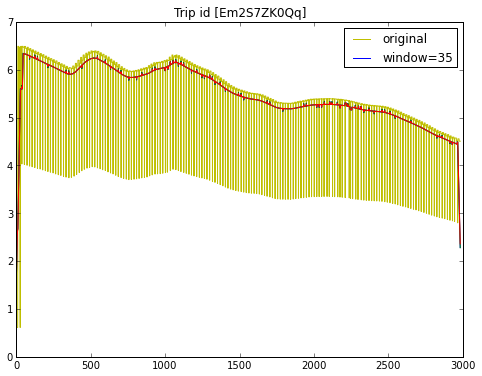

[ 0.  0.]
y5i5udYZ3P
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22y5i5udYZ3P%22%7D
0
moSp48STan
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22moSp48STan%22%7D
3068
False


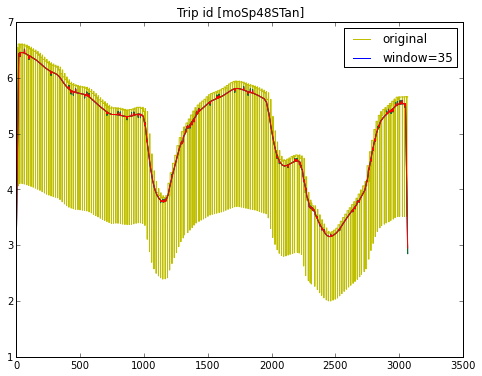

[ 0.  0.]
tFZzXPyw9D
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22tFZzXPyw9D%22%7D
3121
False


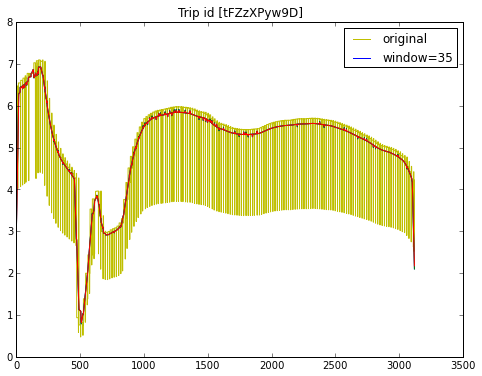

[ 0.  0.]
2iD2ryzmya
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%222iD2ryzmya%22%7D
6434
False


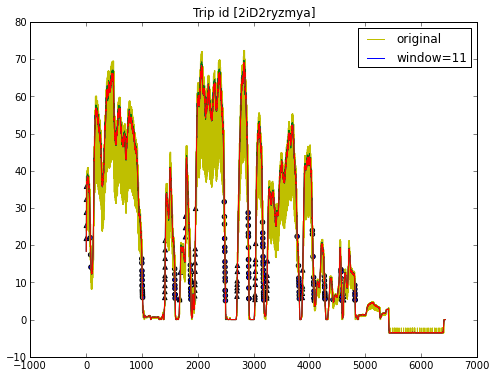

[ 3.35740072  6.93140794]
MXQbGGAhSa
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22MXQbGGAhSa%22%7D
7496
False


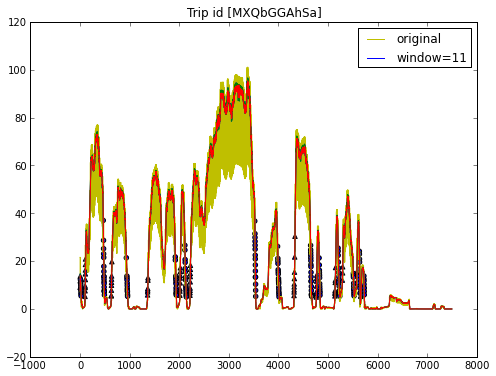

[ 3.61904762  8.19047619]
Pt9Hetudpm
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22Pt9Hetudpm%22%7D
17294
False


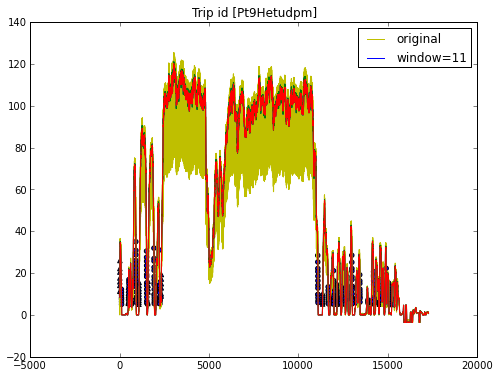

[ 2.1377184   5.52929085]
WPQAslEl8L
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22WPQAslEl8L%22%7D
1778
False


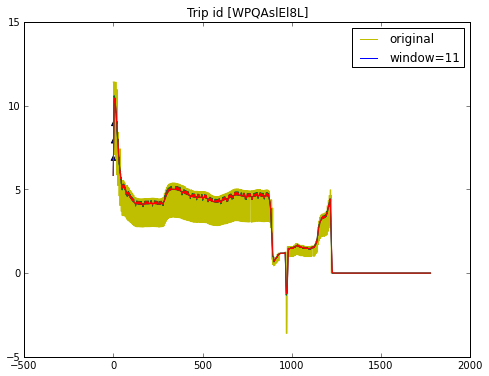

[ 0.59210526  0.        ]
iR9hGfWLaq
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22iR9hGfWLaq%22%7D
14800
False


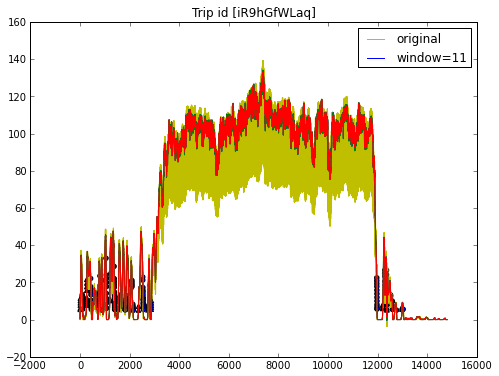

[ 1.74085851  4.45945946]
SyPeXMk0rI
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22SyPeXMk0rI%22%7D
8369
False


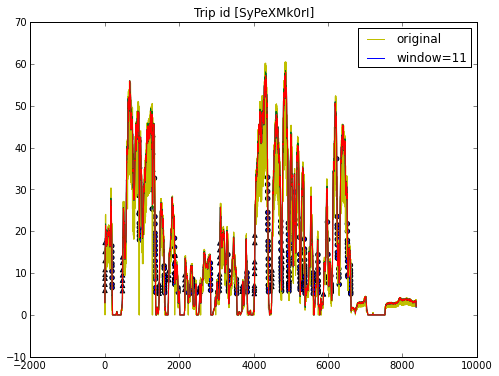

[  3.23633783  11.11426544]
yNHAwNdRzw
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22yNHAwNdRzw%22%7D
4821
False


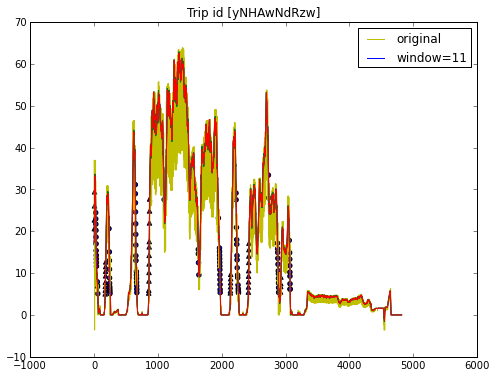

[ 3.08445532  7.12362301]
RBZWsNvGBJ
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22RBZWsNvGBJ%22%7D
6585
False


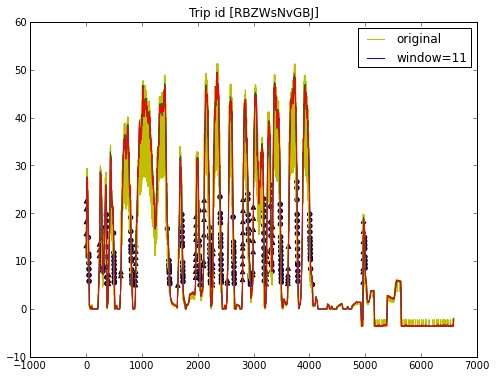

[  4.61538462  11.38111888]
6rrdZNatNC
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%226rrdZNatNC%22%7D
11665
False


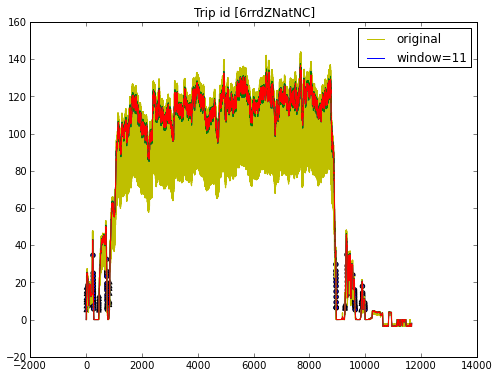

[ 0.98703888  3.110668  ]
25e0tvFLnH
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%2225e0tvFLnH%22%7D
12520
False


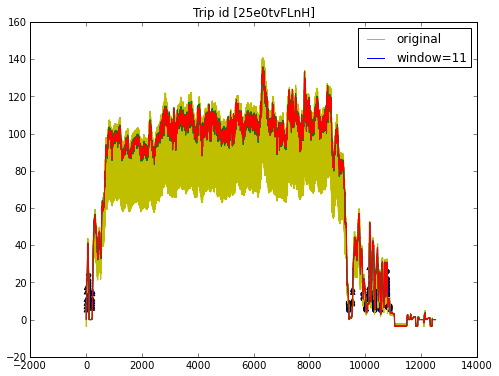

[ 0.94883721  3.32093023]
g2V5kKy0PE
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22g2V5kKy0PE%22%7D
6166
False


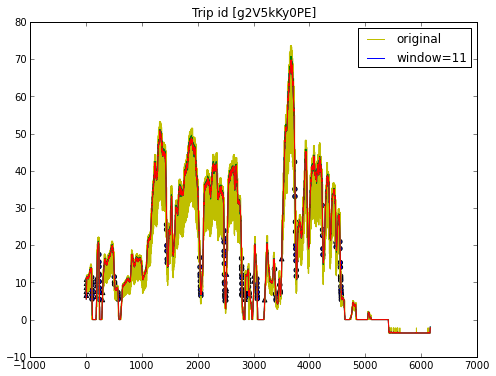

[ 1.39664804  6.64804469]
kXo5kqKxOF
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22kXo5kqKxOF%22%7D
7758
False


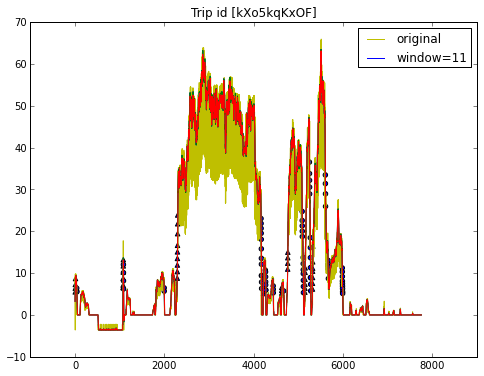

[ 1.98049512  3.51087772]
6mSYxAAlND
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%226mSYxAAlND%22%7D
2113
False


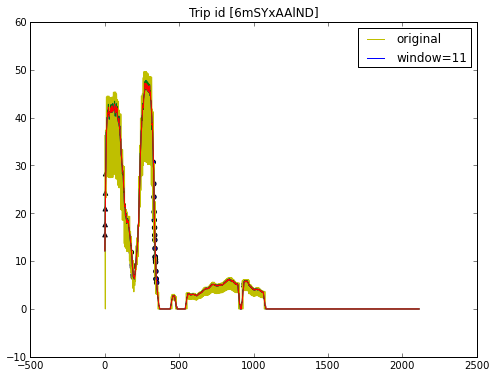

[ 1.17318436  3.68715084]
UwFYzNDQHg
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22UwFYzNDQHg%22%7D
4715
False


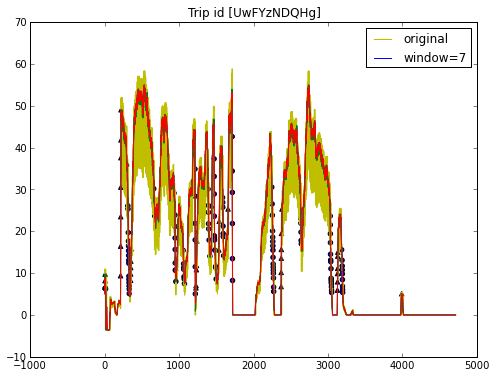

[ 1.64322724  5.41820873]
02F1dXYrq4
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%2202F1dXYrq4%22%7D
1001
False


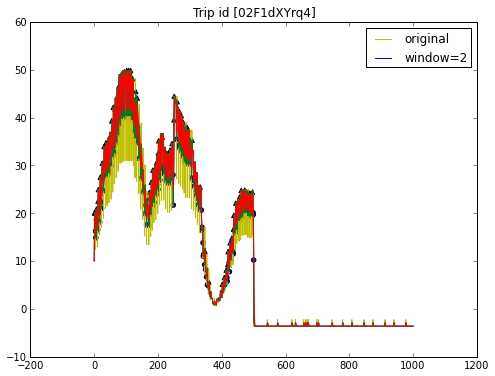

[  7.95918367  13.16326531]
hdF8FY0yC2
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22hdF8FY0yC2%22%7D
501
False


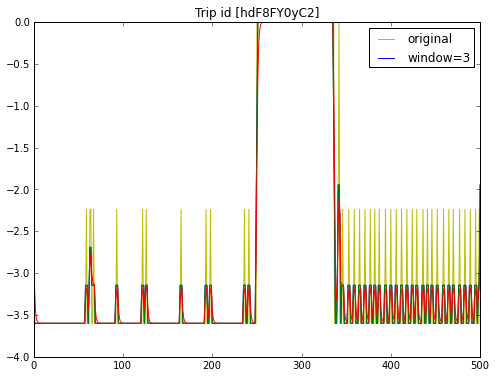

[ 0.  0.]
cJOYwKLuG3
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%22cJOYwKLuG3%22%7D
10441
False


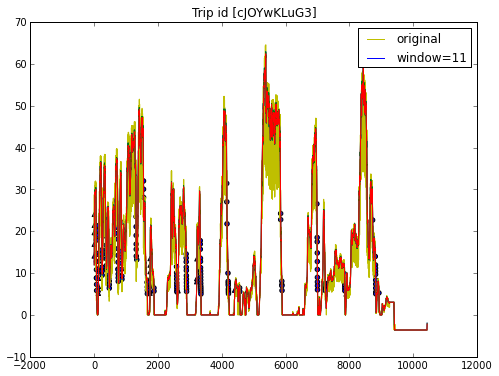

[ 0.9492635   5.46644845]
6WerQaCFup
https://api.parse.com/1/classes/DataPoints?where=%7B%22trip_object_id%22%3A+%226WerQaCFup%22%7D
Error ''

TypeError: 'NoneType' object is not subscriptable

In [23]:
for trip in trips:
    trip_id = trip["objectId"]
    print(trip_id)
    data = get_trip_data_points_from_parse(trip_id)
    if data is None:
        print("No data returned for trip id=[%s]" % trip_id)
        continue
    #data = get_trip_data_points_from_file(trip_id, "/home/shripad/DataPoints.%s.json" % trip_id)
    data_points = concatenate_data_results(trip_id, data)
    print(len(data_points))
    if len(data_points) < 2:
        continue
    sort_trip_data_points(data_points)
    signature = analyze_data(trip_id, data_points, show_plots=True)
    print(signature)
    trip_signatures[trip_id] = signature

In [ ]:
trip_signatures

In [ ]:
# Plot the trips as points in R^2.
# Plot the isocontours, each isocontour denoting trips with
# the same number of acceleration+deceleration events
# per minute. These isocontours allow us to compare
# two trips: one trip is better than another if the
# isovalue of the first is less than that of the second.
x_range = numpy.linspace(0.0, 8.2)
for trip_id, signature in trip_signatures.items():
    x, y = signature
    plt.scatter(x, y)
    #plt.annotate("%s=(%.1f,%.1f)" % (trip_id, x, y), (x, y))
    #plt.plot(x_range, (x + y) - x_range)

In [ ]:
acceleration_event_count = [signature[0] for _, signature in trip_signatures.items()]
plt.hist(acceleration_event_count, bins=100, cumulative=True)
plt.xlabel("Number of acceleration events per minute")
plt.ylabel("Number of trips with at most x acceleration events")
plt.show()
for p in [1, 10, 25, 50, 75, 90, 95, 99]:
    print("%d%%=%f" % (p, numpy.percentile(acceleration_event_count, p)))

In [ ]:
deceleration_event_count = [signature[1] for _, signature in trip_signatures.items()]
plt.hist(deceleration_event_count, bins=100, cumulative=True)
plt.xlabel("Number of deceleration events per minute")
plt.ylabel("Number of trips with at most x deceleration events")
plt.show()
for p in [1, 10, 25, 50, 75, 90, 95, 99]:
    print("%d%%=%f" % (p, numpy.percentile(deceleration_event_count, p)))